In [2]:
import numpy as np
import tables

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("../paper.mplstyle")

from scipy.interpolate import interp2d

In [3]:
mc      = np.load("../data/mcRecarray.npy")
h5f     = tables.File('/data/ana/SterileNeutrino/IC86/HighEnergy/SPE_Templates/Nominal/Ares/IC86.AVG/Merged/Ares_IC86.AVG_0.97_lite_platinum_98000.h5', 'r')
nu_e    = h5f.root.NuEnergy.cols.value[:]
nu_czen = np.cos(h5f.root.NuZenith.cols.value[:])
ow      = h5f.root.oneweight.cols.value[:]/(98000./5.)
nu_i    = h5f.root.PrimaryType.cols.value[:]
events  = zip(nu_e, nu_czen, nu_i)

_        = np.genfromtxt("../data/3y_eff_area.csv", delimiter=",").T
ee       = _[0]
eff_area = _[1]*1e4

## Comparison to Aachen effective areas

In [4]:
arr = np.genfromtxt("../data/aachen_effa.txt", delimiter=",").T
aachen_es = np.power(10,arr[0])
aachen_effa = [
               arr[1],
               arr[2],
               arr[3],
               arr[4],
               arr[5],
               arr[6],
              ]

e         = np.genfromtxt("../data/fluxes_flavor.txt")[:,2]
n         = len(set(e))
e         = e[:n]
cz        = np.genfromtxt("../data/fluxes_flavor.txt")[:,1][::n]
nu_abs    = np.genfromtxt("../data/fluxes_flavor.txt")[:,4].reshape(len(cz), len(e))
nubar_abs = np.genfromtxt("../data/fluxes_flavor.txt")[:,7].reshape(len(cz), len(e))

nu_interp    = interp2d(np.log10(e), np.asarray(cz), nu_abs)
nubar_interp = interp2d(np.log10(e), np.asarray(cz), nubar_abs)

In [5]:
def calc_absorption(event):
    e, c, i = event
    if i==14:
        interp = nu_interp
    elif i==-14:
        interp = nubar_interp
    else:
        print("particle type %d is not valid. Must be 14 or -14" % i)
    return interp(np.log10(e), c)

In [6]:
mc_abs =  np.hstack([calc_absorption(event) for event in events])

In [7]:
e_edges     = np.logspace(2,6,21)
e_widths    = e_edges[1:]-e_edges[:-1]
e_cents     = (e_edges[1:]+e_edges[:-1])/2
czen_edges  = np.asarray([-1, -0.8, -0.6, -0.4, -0.2, max(nu_czen)])
czen_widths = czen_edges[1:]-czen_edges[:-1]
czen_cents  = (czen_edges[1:]+czen_edges[:-1])/2

h_w_abs  = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow*mc_abs)
h_wo_abs = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow)

dOmega = 2*np.pi*czen_widths
# MEOWS_eff_area = np.asarray([arr for arr in ((h[0].T/e_widths).T)/dOmega])
MEOWS_eff_area_w_abs = (h_w_abs[0]/dOmega).T
MEOWS_eff_area_w_abs = ((MEOWS_eff_area_w_abs)/e_widths)[::-1]

MEOWS_eff_area_wo_abs = (h_wo_abs[0]/dOmega).T
MEOWS_eff_area_wo_abs = ((MEOWS_eff_area_wo_abs)/e_widths)[::-1]

#### Make all-sky effective area by hand ####
min_czen = np.min(nu_czen)
max_czen = np.max(nu_czen)
_ = np.asarray([sum(arr) for arr in h_w_abs[0]])/e_widths/(max_czen-min_czen)/(2*np.pi)
MEOWS_eff_area_w_abs  = np.vstack([MEOWS_eff_area_w_abs, _])
_ = np.asarray([sum(arr) for arr in h_wo_abs[0]])/e_widths/(max_czen-min_czen)/(2*np.pi)
MEOWS_eff_area_wo_abs = np.vstack([MEOWS_eff_area_wo_abs, _])

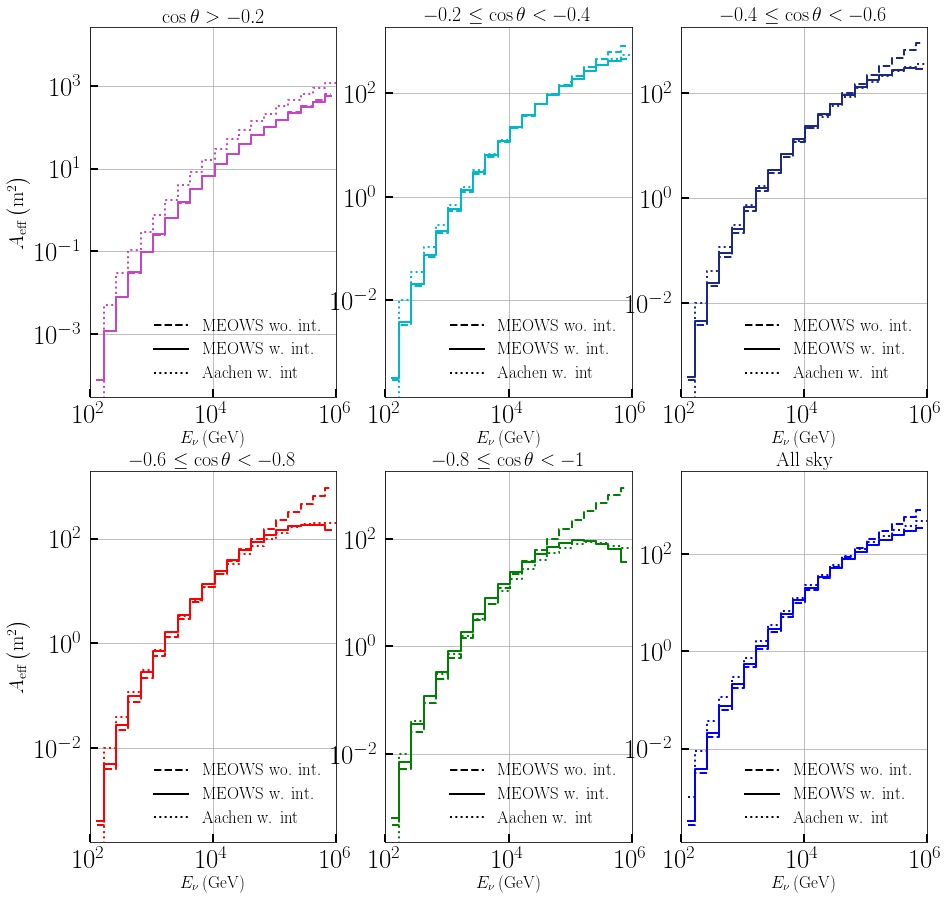

In [8]:
whatever_labels = [
                   r"$\cos\theta > -0.2$",
                   r"$-0.2\leq\cos\theta<-0.4$",
                   r"$-0.4\leq\cos\theta<-0.6$",
                   r"$-0.6\leq\cos\theta<-0.8$",
                   r"$-0.8\leq\cos\theta<-1$",
                   r"All sky",
                   ]

cs = ["#C843C6", "#00B8C8", "#1B2984", "r","g","b"]
lw = 2


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

legend_elements = [
                   Line2D([0], [0], color="black", linestyle="--", label=r"MEOWS wo. int.", lw=lw),
                   Line2D([0], [0], color="black", label="MEOWS w. int.", lw=lw),
                   Line2D([0], [0], color="black", linestyle="dotted", label=r"Aachen w. int", lw=lw),
                  ]

for i in range(6):
    a = ax[i/3][i%3]
    a.step(e_cents, MEOWS_eff_area_w_abs[i]/1e4, color=cs[i], where='mid', label=whatever_labels[i])
    a.step(e_cents, MEOWS_eff_area_wo_abs[i]/1e4, color=cs[i], linestyle="--", where='mid')
    if i!=5:
        a.step(aachen_es, 5*np.asarray(aachen_effa[i]), linestyle="dotted", color=cs[i], where="mid")
    else:
        a.step(aachen_es, np.asarray(aachen_effa[i]), linestyle="dotted", color=cs[i], where="mid")

    a.loglog()
    a.set_title(whatever_labels[i], fontsize="20")
#     a.legend(frameon=False, loc="lower right", fontsize=18)
    a.set_xlabel(r"$E_{\nu} \left(\rm{GeV}\right)$", fontsize=17)
    a.legend(handles=legend_elements, loc='lower right', ncol=1, prop={"size":17}, frameon=False)
    a.set_xlim(1e2,1e6)
    a.grid()
    if i==0 or i==3:
        a.set_ylabel(r"$A_{\rm{eff}} \left(\rm{m}^{2}\right)$", fontsize=20)
plt.show()

In [9]:
np.savetxt("/data/user/jlazar/meows_eff_a.dat",np.vstack([e_cents,MEOWS_eff_area_w_abs*1e-4, MEOWS_eff_area_wo_abs*1e-4]).T)

In [11]:
np.degrees(np.arccos(max(cz)))

84.26082952273322

In [ ]:
# cs              = ["#C843C6", "#00B8C8", "#1B2984", "r","g","b", "yellow"]
zen_band_labels = [
                   r"$\cos\theta > -0.2$",
                   r"$-0.2\leq\cos\theta<-0.4$",
                   r"$-0.4\leq\cos\theta<-0.6$",
                   r"$-0.6\leq\cos\theta<-0.8$",
                   r"$-0.8\leq\cos\theta<-1$",
                   r"All sky",
                   ]



for i, arr in enumerate(MEOWS_eff_area_wo_abs):
    plt.step(e_cents, arr*1e-4, color=cs[i], label=zen_band_labels[i], lw=2)
# plt.step(e_cents, _)
plt.loglog()
plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel(r"$A_{\rm{eff}}$ (m$^{2}$)")
plt.title(r"MEOWS effective area")
plt.legend(frameon=False)
plt.show()

In [53]:
e         = np.genfromtxt("data/fluxes_flavor.txt")[:,2]
n         = len(set(e))
e         = e[:n]
cz      = np.genfromtxt("data/fluxes_flavor.txt")[:,1][::n]
nu_r    = np.genfromtxt("data/fluxes_flavor.txt")[:,4].reshape(len(cz), len(e))
nubar_r = np.genfromtxt("data/fluxes_flavor.txt")[:,7].reshape(len(cz), len(e))

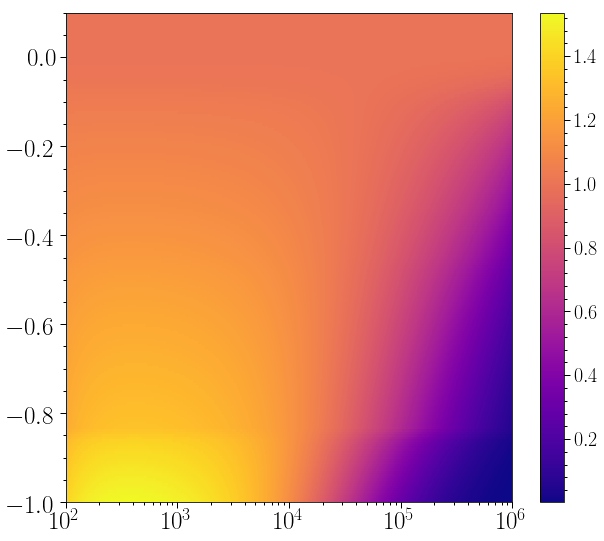

In [54]:
X,Y=np.meshgrid(e, cz)

fig = plt.figure(figsize=(10,9))
im  = plt.pcolor(X, Y, nu_r)

plt.xscale('log')
# plt.yscale('log')

cbar = plt.colorbar(im, orientation='vertical')
cbar.ax.tick_params(labelsize=20) 

plt.tick_params(labelsize=25)

plt.show()

In [10]:
mc      = np.load("data/mcRecarray.npy")
nu_e    = mc["nuE"]
nu_czen = np.cos(mc["nuZen"])
ow      = mc["oneWeight"]*1e-4
nu_i    = mc["i"]

In [12]:
e_edges     = np.logspace(2,6,21)
e_widths    = e_edges[1:]-e_edges[:-1]
e_cents     = (e_edges[1:]+e_edges[:-1])/2
czen_edges  = np.asarray([-1, -0.8, -0.6, -0.4, -0.2, max(nu_czen)])
czen_widths = czen_edges[1:]-czen_edges[:-1]
czen_cents  = (czen_edges[1:]+czen_edges[:-1])/2

h_wo_abs = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow)

dOmega = 2*np.pi*czen_widths

MEOWS_eff_area_wo_abs = (h_wo_abs[0]/dOmega).T
MEOWS_eff_area_wo_abs = ((MEOWS_eff_area_wo_abs)/e_widths)[::-1]

In [26]:
e_edges     = np.logspace(2,6,21)
e_widths    = e_edges[1:]-e_edges[:-1]
e_cents     = (e_edges[1:]+e_edges[:-1])/2
czen_edges  = np.asarray([max(nu_czen), np.cos(np.radians(85)), np.cos(np.radians(120)), -1])[::-1]
czen_widths = czen_edges[1:]-czen_edges[:-1]
czen_cents  = (czen_edges[1:]+czen_edges[:-1])/2

h_w_abs  = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow*mc_abs)
h_wo_abs = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow)

dOmega = 2*np.pi*czen_widths
# MEOWS_eff_area = np.asarray([arr for arr in ((h[0].T/e_widths).T)/dOmega])
MEOWS_eff_area_w_abs = (h_w_abs[0]/dOmega).T
MEOWS_eff_area_w_abs = ((MEOWS_eff_area_w_abs)/e_widths)[::-1]

MEOWS_eff_area_wo_abs = (h_wo_abs[0]/dOmega).T
MEOWS_eff_area_wo_abs = ((MEOWS_eff_area_wo_abs)/e_widths)[::-1]

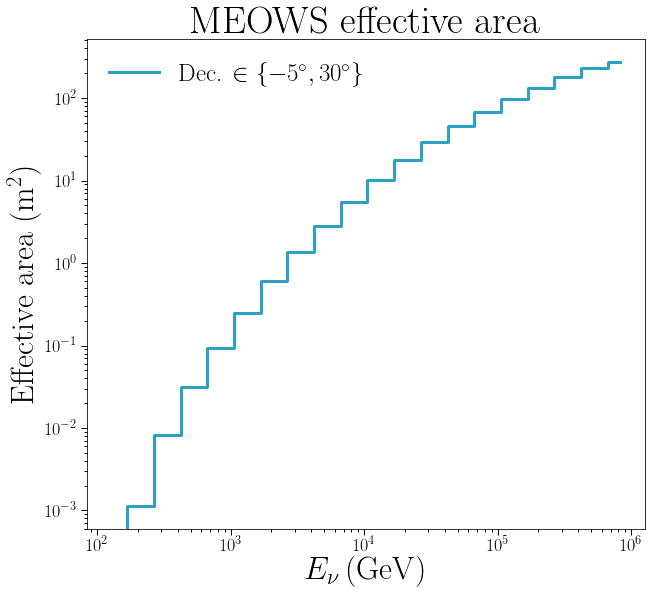

In [40]:
fig = plt.figure(figsize=(10,9))
plt.step(e_cents, MEOWS_eff_area_w_abs[1]/1e4, lw=3, where="mid", label=r"Dec. $\in\left\{-5^\circ,30^\circ\right\}$")

plt.legend(frameon=False)
plt.xlabel(r"$E_{\nu} \left(\rm{GeV}\right)$")
plt.ylabel(r"Effective area (m$^{2}$)")
plt.loglog()
plt.title(r"MEOWS effective area")

plt.show()

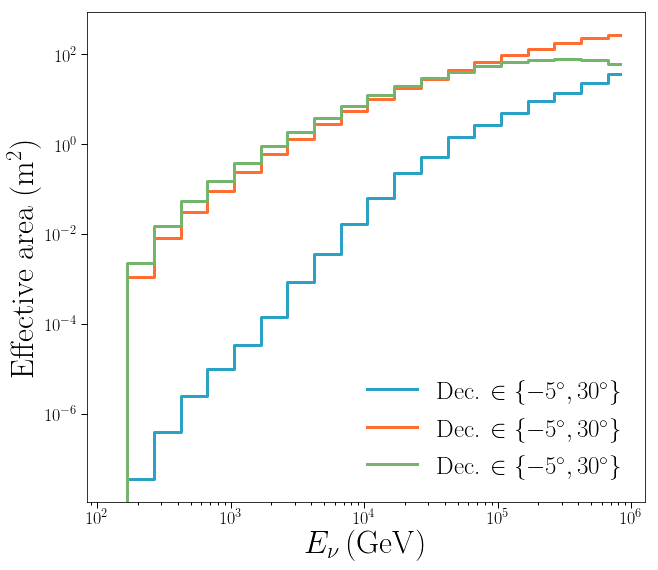

In [38]:
fig = plt.figure(figsize=(10,9))
for _ in MEOWS_eff_area_w_abs:
    plt.step(e_cents, _/1e4, lw=3, where="mid", label=r"Dec. $\in\left\{-5^\circ,30^\circ\right\}$")

plt.legend(frameon=False)
plt.xlabel(r"$E_{\nu} \left(\rm{GeV}\right)$")
plt.ylabel(r"Effective area (m$^{2}$)")
plt.loglog()

plt.show()

In [59]:
max(nu_czen)

0.17061761273228046

In [63]:
np.degrees(min(mc["nuZen"]))

80.17626970307647

In [62]:
min(mc["recoZen"])

1.470629264363688

In [65]:
np.cos(np.radians(85))

0.08715574274765814

In [74]:
a_MEOWS = [0.37,0.2,0.2,0.2,0.2]
a_aachen = [0.2,0.2,0.2,0.2,0.2]

thing1 = 0
thing2 = 0
for i in range(len(a_MEOWS)):
    thing1 += MEOWS_eff_area_wo_abs[i]*a_MEOWS[i]
    thing2 += np.asarray(aachen_effa)[i]* a_aachen[i]
# print(thing1 / np.sum(a_MEOWS))
print(thing2 / np.sum(a_aachen))

[0.000000e+00 1.800000e-03 7.400000e-03 2.260000e-02 5.980000e-02
 1.456000e-01 3.276000e-01 6.906000e-01 1.365400e+00 2.544600e+00
 4.503200e+00 7.452200e+00 1.182900e+01 1.777680e+01 2.557180e+01
 3.512380e+01 4.743440e+01 6.120540e+01 7.641560e+01 9.390460e+01
 1.145502e+02 1.356978e+02 1.579078e+02 1.849386e+02 2.191120e+02
 2.389466e+02 2.997636e+02 3.543388e+02 3.714652e+02 4.387718e+02]


In [75]:
# print(MEOWS_eff_area_wo_abs[-1])
print(thing2/aachen_effa[-1])

[0.         0.2        0.2        0.2        0.19933333 0.2
 0.1997561  0.19976859 0.19976591 0.1996391  0.19955686 0.19949672
 0.19950078 0.19934735 0.19923646 0.19910323 0.19883885 0.19865562
 0.19853622 0.19836416 0.1979772  0.19756109 0.19740301 0.19674319
 0.1967878  0.1955298  0.19634909 0.19602668 0.19484062 0.19445183]


In [76]:
np.asarray(aachen_effa).shape

(6, 30)

In [73]:
_ = np.genfromtxt("data/3y_eff_area.csv", delimiter=",").T
thr_yr_ee = _[0]
thr_yr_ea = _[1]

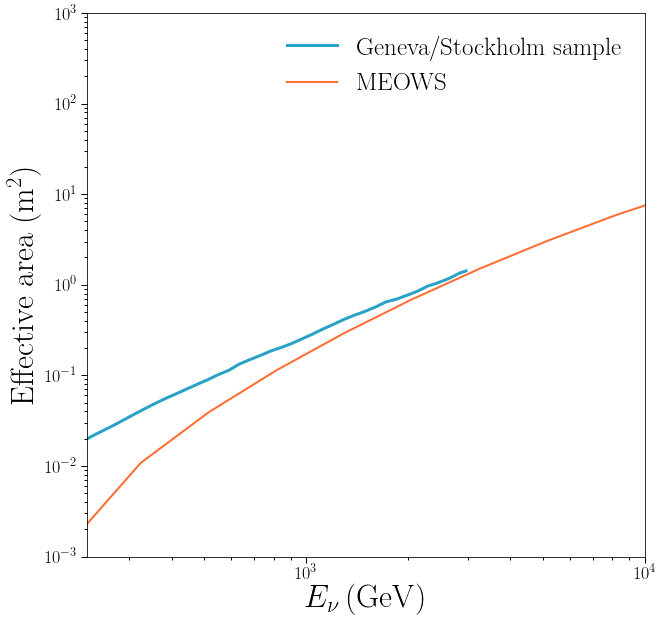

In [81]:
plt.plot(thr_yr_ee, thr_yr_ea, lw=3, label=r"Geneva/Stockholm sample")
# plt.step(e_cents, MEOWS_eff_area_w_abs[-1]*1e-4, lw=2, label=r"MEOWS w. interactions", where="mid")
# plt.step(e_cents, MEOWS_eff_area_wo_abs[-1]*1e-4, lw=2, label=r"MEOWS wo. interactions", where="mid")
plt.plot(e_cents, MEOWS_eff_area_w_abs[-1]*1e-4, lw=2, label=r"MEOWS",)
# plt.plot(e_cents, MEOWS_eff_area_wo_abs[-1]*1e-4, lw=2, label=r"MEOWS wo. interactions",)

plt.loglog()
plt.xlabel(r"$E_{\nu} \left(\rm{GeV}\right)$")
plt.ylabel(r"Effective area (m$^{2}$)")
plt.xlim(225, 10000)
plt.ylim(1e-3,1e3)

plt.legend(frameon=False)
plt.show()

In [135]:
e_cents

array([1.29244660e+02, 2.04838981e+02, 3.24647907e+02, 5.14532258e+02,
       8.15478672e+02, 1.29244660e+03, 2.04838981e+03, 3.24647907e+03,
       5.14532258e+03, 8.15478672e+03, 1.29244660e+04, 2.04838981e+04,
       3.24647907e+04, 5.14532258e+04, 8.15478672e+04, 1.29244660e+05,
       2.04838981e+05, 3.24647907e+05, 5.14532258e+05, 8.15478672e+05])

In [91]:
min_czen = np.min(nu_czen)
max_czen = np.max(nu_czen)

_ = np.histogram(nu_e, bins=e_edges, weights=ow)

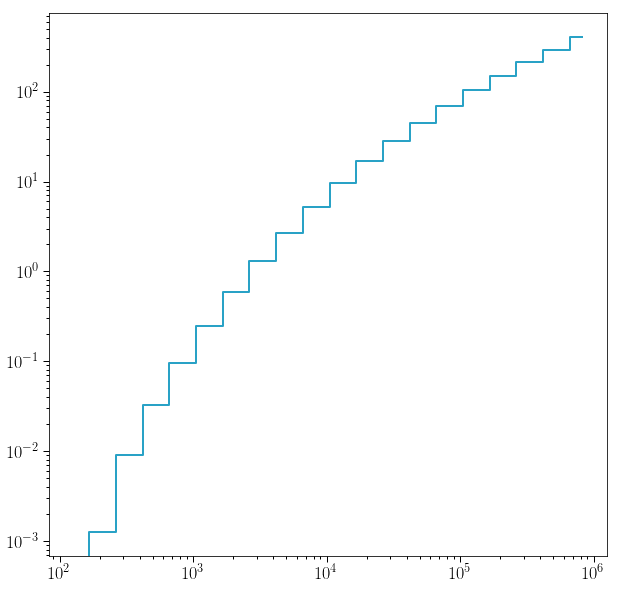

In [93]:
d_Omega = 2*np.pi*(max_czen-min_czen)
eff_a   = _[0]/e_widths/d_Omega*1e-4
plt.step(e_cents, eff_a, where="mid")

plt.loglog()
plt.show()

In [145]:
e_edges     = np.logspace(2,6,201)
e_widths    = e_edges[1:]-e_edges[:-1]
e_cents     = (e_edges[1:]+e_edges[:-1])/2
czen_edges  = np.asarray([-1, -0.8, -0.6, -0.4, -0.2, max(nu_czen)])
czen_widths = czen_edges[1:]-czen_edges[:-1]
czen_cents  = (czen_edges[1:]+czen_edges[:-1])/2

h_w_abs  = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow*mc_abs)
h_wo_abs = np.histogram2d(nu_e, nu_czen, bins=[e_edges, czen_edges], weights=ow)

dOmega = 2*np.pi*czen_widths
# MEOWS_eff_area = np.asarray([arr for arr in ((h[0].T/e_widths).T)/dOmega])
MEOWS_eff_area_w_abs = (h_w_abs[0]/dOmega).T
MEOWS_eff_area_w_abs = ((MEOWS_eff_area_w_abs)/e_widths)[::-1]

MEOWS_eff_area_wo_abs = (h_wo_abs[0]/dOmega).T
MEOWS_eff_area_wo_abs = ((MEOWS_eff_area_wo_abs)/e_widths)[::-1]

#### Make all-sky effective area by hand ####
min_czen = np.min(nu_czen)
max_czen = np.max(nu_czen)
_ = np.asarray([sum(arr) for arr in h_w_abs[0]])/e_widths/(max_czen-min_czen)/(2*np.pi)
MEOWS_eff_area_w_abs  = np.vstack([MEOWS_eff_area_w_abs, _])
_ = np.asarray([sum(arr) for arr in h_wo_abs[0]])/e_widths/(max_czen-min_czen)/(2*np.pi)
MEOWS_eff_area_wo_abs = np.vstack([MEOWS_eff_area_wo_abs, _])

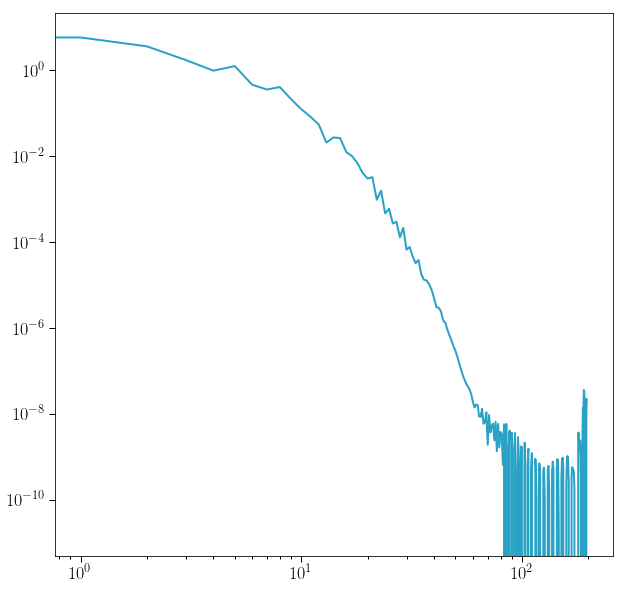

In [149]:
plt.plot(np.load("data/qr_dn_dz/ch8_m10000_dn_dz.npy")[0][0])
plt.loglog()
plt.show()

In [62]:
h5f = tables.File('/data/ana/SterileNeutrino/IC86/HighEnergy/SPE_Templates/Nominal/Ares/IC86.AVG/Merged/Ares_IC86.AVG_0.97_lite_platinum_98000.h5', 'r')
e_edges  = np.logspace(2,8,61)
e_widths = e_edges[1:]-e_edges[:-1]
d_omega  = 2*np.pi*(np.max(np.cos(h5f.root.NuZenith.cols.value[:]))-np.min(np.cos(h5f.root.NuZenith.cols.value[:])))

nu_e_dig   = np.digitize(h5f.root.NuEnergy.cols.value[:], e_edges)-1
reco_e_dig = np.digitize(h5f.root.MuExEnergy.cols.value[:], e_edges)-1

nu_e_widths   = e_widths[nu_e_dig]
reco_e_widths = e_widths[reco_e_dig]

nu_e_aeff   = h5f.root.oneweight.cols.value[:]/nu_e_widths/d_omega*1e-8
reco_e_aeff = h5f.root.oneweight.cols.value[:]/reco_e_widths/d_omega*1e-8

In [68]:
h1 = np.histogram(h5f.root.MuExEnergy.cols.value[:], e_edges, weights=reco_e_aeff)
h2 = np.histogram(h5f.root.NuEnergy.cols.value[:], e_edges, weights=nu_e_aeff)

[]

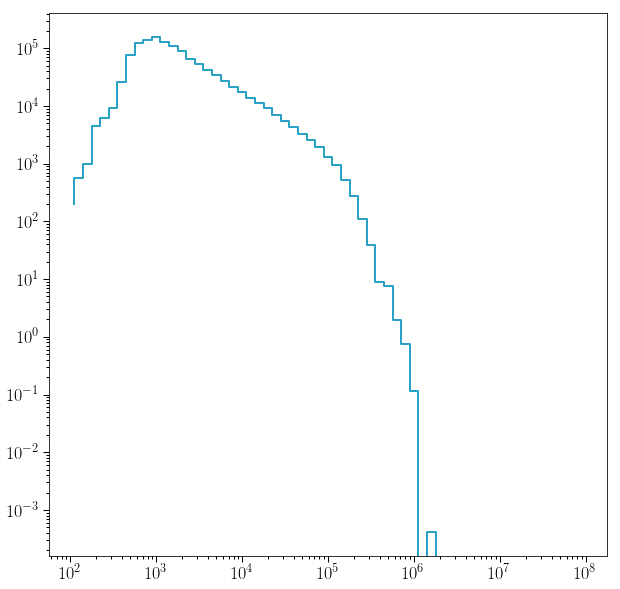

In [66]:
plt.step((e_edges[1:]+e_edges[:-1])/2, h[0])
plt.loglog()

In [47]:
import tables

In [59]:
nu_zen = h5f.root.NuZenith.cols.value[:]

In [70]:
np.histogram2d(h5f.root.MuExEnergy.cols.value[:], h5f.root.NuEnergy.cols.value[:], bins=[e_edges,e_edges], weights=h5f.root.oneweight.cols.value[:])

(array([[  7134.7286719 ,  35127.09713513, 122330.38342664, ...,
              0.        ,      0.        ,      0.        ],
        [ 14132.02375797,  61618.15964437, 197516.10275259, ...,
              0.        ,      0.        ,      0.        ],
        [ 22062.16488301, 115610.90847557, 370154.23615971, ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]]),
 array([1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
        2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
        6.30957344e+02, 7.94328235e+02, 1.00000000e+03, 1.25892541e+03,
        1.584